<a href="https://colab.research.google.com/github/samanvithkashyap/QPrice/blob/main/QPrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit
!pip install qiskit_aer
!pip install qiskit_algorithms
!pip install qiskit_machine_learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 7.3 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from qiskit_aer.primitives import Estimator
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.algorithms.regressors import VQR
import matplotlib.pyplot as plt

In [ ]:
CHOSEN_EXPIRATION_DATE = '2026-03-31'
ticker = yf.Ticker("SPY")

print(f"Fetching data for date: {CHOSEN_EXPIRATION_DATE} ")

# Get current stock price
try:
    current_price = ticker.history(period="1d")['Close'].iloc[-1]
except IndexError:
    info = ticker.info
    current_price = (info.get('bid', 0) + info.get('ask', 0)) / 2
    if current_price == 0:
        current_price = info.get('previousClose', 1)

print(f"Current Stock Price (S): ${current_price:.2f}")

# Fetch options data
calls_df = ticker.option_chain(CHOSEN_EXPIRATION_DATE).calls

# Clean the data
cleaned_df = calls_df[
    (calls_df['openInterest'] > 0) &
    (calls_df['bid'] > 0) &
    (calls_df['ask'] > 0)
].copy()

cleaned_df['targetPrice'] = (cleaned_df['bid'] + cleaned_df['ask']) / 2
print(f"Original options: {len(calls_df)}, Cleaned options: {len(cleaned_df)}")

if len(cleaned_df) == 0:
    print("\nERROR: No data points found ")
    exit()

print(f"\n✓ Using {len(cleaned_df)} data points")

Fetching data for date: 2026-03-31 
Current Stock Price (S): $675.37
Original options: 161, Cleaned options: 150

✓ Using 150 data points


In [ ]:
cleaned_df['moneyness'] = current_price / cleaned_df['strike']

expiration_date = datetime.datetime.strptime(CHOSEN_EXPIRATION_DATE, '%Y-%m-%d').date()
today_date = datetime.date.today()
days_to_expiration = (expiration_date - today_date).days
cleaned_df['time_to_maturity'] = days_to_expiration / 365.25

cleaned_df['implied_volatility'] = cleaned_df['impliedVolatility']

print("\nEngineered Features (Sample)")
print(cleaned_df[['strike', 'moneyness', 'time_to_maturity', 'implied_volatility', 'targetPrice']].head())


Engineered Features (Sample)
   strike  moneyness  time_to_maturity  implied_volatility  targetPrice
0   345.0   1.957594          0.375086            0.640751      333.760
1   350.0   1.929629          0.375086            0.000010      302.370
2   355.0   1.902451          0.375086            0.626835      324.045
3   360.0   1.876028          0.375086            0.000010      292.725
4   365.0   1.850329          0.375086            0.000010      268.470


In [ ]:
feature_cols = ['moneyness', 'time_to_maturity', 'implied_volatility']
target_col = 'targetPrice'

X = cleaned_df[feature_cols].values
Y = cleaned_df[target_col].values.reshape(-1, 1)

# Initialize scalers
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the data
X_scaled = x_scaler.fit_transform(X)
Y_scaled = y_scaler.fit_transform(Y)

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled,
    Y_scaled,
    test_size=0.3,
    random_state=42
)

print("Data Ready")
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

Data Ready
X_train shape: (105, 3)
Y_train shape: (105, 1)
X_test shape: (45, 3)
Y_test shape: (45, 1)


In [ ]:
print("Building Quantum Model (VQR)")

estimator = Estimator()
feature_map = ZFeatureMap(feature_dimension=3, reps=1)
ansatz = RealAmplitudes(num_qubits=3, reps=3)
optimizer = SPSA(maxiter=100)

print("Components defined")

# Callback function to monitor training
iteration_costs = []
def callback(weights, objective_function_value):
    iteration_costs.append(objective_function_value)
    if len(iteration_costs) % 10 == 0:
        print(f"Iteration {len(iteration_costs)}: Cost = {objective_function_value:.6f}")

# Initialize and train VQR
print("\nTraining VQR model")
start_time = time.time()

vqr = VQR(
    estimator=estimator,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback
)

vqr.fit(X_train, Y_train.ravel())

training_time = time.time() - start_time
print(f"\nTraining Complete in {training_time:.2f} seconds")

Building Quantum Model (VQR)
Components defined

Training VQR model

Training Complete in 44.67 seconds


In [ ]:
print("Evaluating Model Performance")

# Make predictions
Y_train_pred_scaled = vqr.predict(X_train)
Y_test_pred_scaled = vqr.predict(X_test)

# Unscale predictions
Y_train_pred = y_scaler.inverse_transform(Y_train_pred_scaled.reshape(-1, 1))
Y_test_pred = y_scaler.inverse_transform(Y_test_pred_scaled.reshape(-1, 1))
Y_train_actual = y_scaler.inverse_transform(Y_train)
Y_test_actual = y_scaler.inverse_transform(Y_test)

# Calculate metrics
train_mse = mean_squared_error(Y_train_actual, Y_train_pred)
test_mse = mean_squared_error(Y_test_actual, Y_test_pred)
train_mae = mean_absolute_error(Y_train_actual, Y_train_pred)
test_mae = mean_absolute_error(Y_test_actual, Y_test_pred)
train_r2 = r2_score(Y_train_actual, Y_train_pred)
test_r2 = r2_score(Y_test_actual, Y_test_pred)

print("\nTRAINING SET METRICS ")
print(f"MSE:  ${train_mse:.4f}")
print(f"MAE:  ${train_mae:.4f}")
print(f"R²:   {train_r2:.4f}")

print("\nTEST SET METRICS ")
print(f"MSE:  ${test_mse:.4f}")
print(f"MAE:  ${test_mae:.4f}")
print(f"R²:   {test_r2:.4f}")

Evaluating Model Performance

TRAINING SET METRICS 
MSE:  $2187.4303
MAE:  $36.7203
R²:   0.6683

TEST SET METRICS 
MSE:  $2666.2385
MAE:  $40.2078
R²:   0.6292


In [ ]:
print("\nExample: Price a Specific Option")

# Choose a strike price to price
example_strike = current_price * 1.05  # 5% out of the money

example_features = np.array([[
    current_price / example_strike,  # moneyness
    days_to_expiration / 365.25,      # time to maturity
    cleaned_df['implied_volatility'].median()  # avg implied vol
]])

print(f"\nPricing call option with strike ${example_strike:.2f}")
print(f"Features: Moneyness={example_features[0,0]:.4f}, TTM={example_features[0,1]:.4f}, IV={example_features[0,2]:.4f}")

# Scale and predict
example_scaled = x_scaler.transform(example_features)
predicted_price_scaled = vqr.predict(example_scaled)
predicted_price = y_scaler.inverse_transform(predicted_price_scaled.reshape(-1, 1))[0, 0]

print(f"Predicted Option Price: ${predicted_price:.2f}")


Example: Price a Specific Option

Pricing call option with strike $709.14
Features: Moneyness=0.9524, TTM=0.3751, IV=0.2545
Predicted Option Price: $83.72


In [18]:
#running a classical model
print("\nBuilding and Training Classical Model (Random Forest)")

from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train.ravel())

print("Classical Model Trained.")


Building and Training Classical Model (Random Forest)
Classical Model Trained.


In [20]:
print("\nEvaluating Classical Model Performance")

Y_test_pred_scaled_rf = rf_model.predict(X_test)
Y_test_pred_rf = y_scaler.inverse_transform(Y_test_pred_scaled_rf.reshape(-1, 1))

# Calculate metrics
test_mse_rf = mean_squared_error(Y_test_actual, Y_test_pred_rf)
test_mae_rf = mean_absolute_error(Y_test_actual, Y_test_pred_rf)
test_r2_rf = r2_score(Y_test_actual, Y_test_pred_rf)

print("\nCLASSICAL (RF) TEST SET METRICS ")
print(f"MSE:  ${test_mse_rf:.4f}")
print(f"MAE:  ${test_mae_rf:.4f}")
print(f"R²:   {test_r2_rf:.4f}")

print("\nMETRIC COMPARISON")
print(f"VQR Test R²:  {test_r2:.4f}")
print(f"RF  Test R²:  {test_r2_rf:.4f}")


Evaluating Classical Model Performance

CLASSICAL (RF) TEST SET METRICS 
MSE:  $96.9612
MAE:  $6.2455
R²:   0.9865

METRIC COMPARISON
VQR Test R²:  0.6292
RF  Test R²:  0.9865



Some Stats


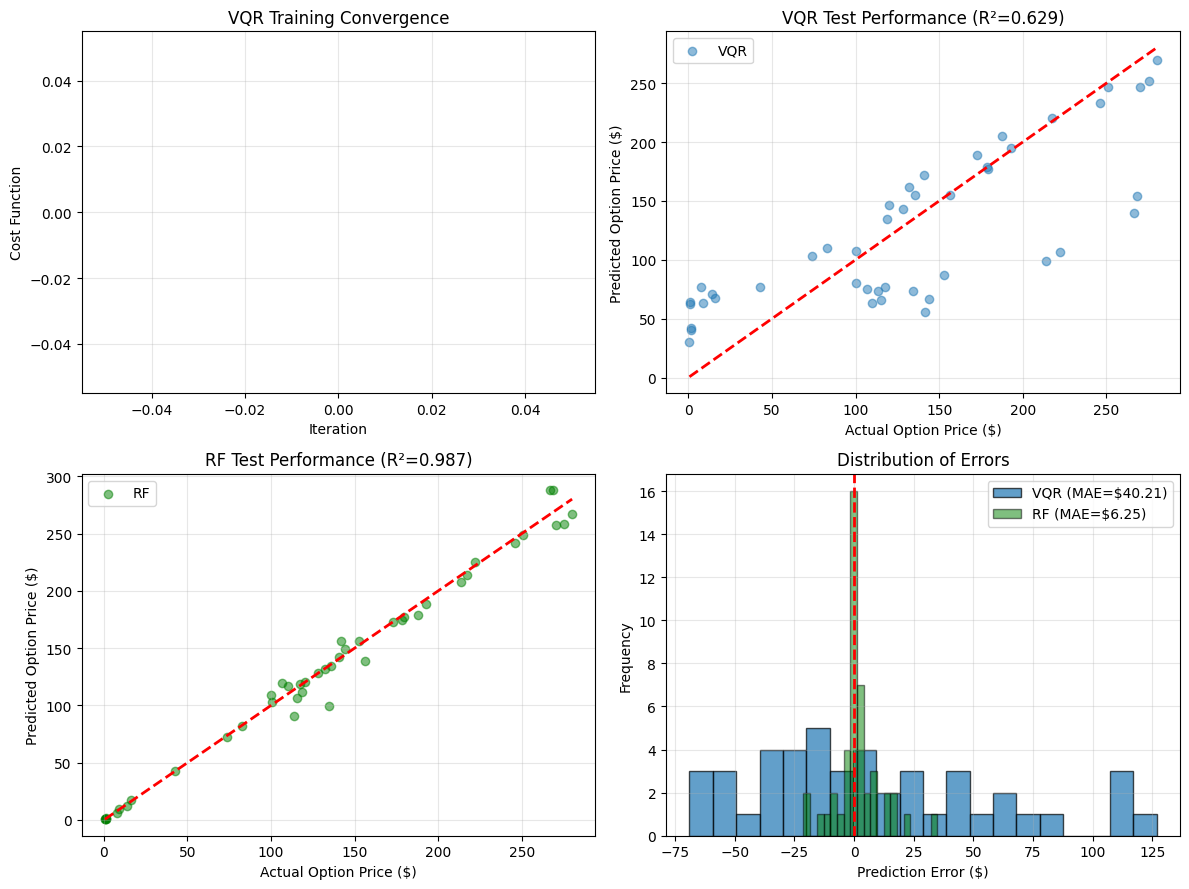

In [21]:
print("\nSome Stats")

# Create a 2x2 plot figure
plt.figure(figsize=(12, 9))

# --- Plot 1: VQR Training convergence ---
plt.subplot(2, 2, 1)
plt.plot(iteration_costs)
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('VQR Training Convergence')
plt.grid(True, alpha=0.3)

# --- Plot 2: VQR Actual vs Predicted (Test Set) ---
plt.subplot(2, 2, 2)
plt.scatter(Y_test_actual, Y_test_pred, alpha=0.5, label='VQR')
plt.plot([Y_test_actual.min(), Y_test_actual.max()],
         [Y_test_actual.min(), Y_test_actual.max()],
         'r--', lw=2)
plt.xlabel('Actual Option Price ($)')
plt.ylabel('Predicted Option Price ($)')
plt.title(f'VQR Test Performance (R²={test_r2:.3f})')
plt.grid(True, alpha=0.3)
plt.legend()

# --- Plot 3: RF Actual vs Predicted (Test Set) ---
plt.subplot(2, 2, 3)
plt.scatter(Y_test_actual, Y_test_pred_rf, alpha=0.5, color='green', label='RF')
plt.plot([Y_test_actual.min(), Y_test_actual.max()],
         [Y_test_actual.min(), Y_test_actual.max()],
         'r--', lw=2)
plt.xlabel('Actual Option Price ($)')
plt.ylabel('Predicted Option Price ($)')
plt.title(f'RF Test Performance (R²={test_r2_rf:.3f})')
plt.grid(True, alpha=0.3)
plt.legend()

# --- Plot 4: Prediction errors (Both models) ---
plt.subplot(2, 2, 4)
errors_vqr = Y_test_actual - Y_test_pred
errors_rf = Y_test_actual - Y_test_pred_rf
plt.hist(errors_vqr, bins=20, edgecolor='black', alpha=0.7, label=f'VQR (MAE=${test_mae:.2f})')
plt.hist(errors_rf, bins=20, edgecolor='black', alpha=0.5, color='green', label=f'RF (MAE=${test_mae_rf:.2f})')
plt.xlabel('Prediction Error ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Errors')
plt.axvline(x=0, color='r', linestyle='--', lw=2)
plt.grid(True, alpha=0.3)
plt.legend()

# Save and show the plot
plt.tight_layout()
plt.savefig('vqr_rf_results.png', dpi=150, bbox_inches='tight')
plt.show()

In [23]:
print("MODEL SUMMARY\n")
print(f"Stock: SPY")
print(f"Current Price: ${current_price:.2f}")
print(f"Expiration: {CHOSEN_EXPIRATION_DATE}")
print(f"Days to Expiration: {days_to_expiration}")
print(f"Training Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")

print("\nVQR MODEL")
print(f"  Test MAE: ${test_mae:.4f}")
print(f"  Test R²:  {test_r2:.4f}")
print(f"  Training Time: {training_time:.2f}s")

print("\nCLASSICAL RF MODEL")
print(f"  Test MAE: ${test_mae_rf:.4f}")
print(f"  Test R²:  {test_r2_rf:.4f}")

MODEL SUMMARY

Stock: SPY
Current Price: $675.37
Expiration: 2026-03-31
Days to Expiration: 137
Training Samples: 105
Test Samples: 45

VQR MODEL
  Test MAE: $40.2078
  Test R²:  0.6292
  Training Time: 44.67s

CLASSICAL RF MODEL
  Test MAE: $6.2455
  Test R²:  0.9865
